In [29]:
%reload_ext autoreload
%autoreload 2

In [30]:
import networkx as nx
import numpy as np
import pandas as pd
from dowhy import gcm
from matplotlib import pyplot as plt

from CausalSDG import (make_dist_from_dataframe2,ConditionalMechanismFromDict,
                       Str2ListProcessing, FunctionApplying, CausalGenerator)

# 1 - Import the training data

In [31]:
cv_dt = pd.read_json('cvs.json',dtype={
    "gender": "str",
    "ethnic_group": "str",
    "religion": "str",
    "disability": "str",
    "sexual_orientation": "str",
    "perceived_foreign": "str",
    "job_cat": "str",
    "edu_eqf": "str",
    "years_exp": "str",
    "age": "str",
    "skills": "object",
    "prof_exp": "object",
})

In [32]:
cv_dt

,gender,ethnic_group,religion,disability,sexual_orientation,perceived_foreign,job_cat,edu_eqf,age,years_exp,skills,prof_exp
0,Man,No answer,Judaism,No,LGBT+,Yes,Teaching professionals,level 6,26,1,"[Swedish, Italian, public administration]",[]
1,Man,Within majority,Christianity,No,Heterosexual,Yes,"Agricultural, forestry and fishery labourers",level 6,20,4,"[office software, hydraulics, manage teamwork,...",[]
2,No-Man,Within majority,Secular,No,Heterosexual,No,"Legal, social and cultural professionals",level 5 or less,32,14,"[teach teaching principles, perform mathematic...",[university teaching assistant]
3,Man,Within majority,Christianity,No answer,Heterosexual,No,"Agricultural, forestry and fishery labourers",level 6,36,14,"[analyse the context of an organisation, adapt...",[dry press operator]
4,No-Man,"Belonging to both, minority and majority",None,No answer,Heterosexual,Yes,Other clerical support workers,level 6,35,8,"[leading and motivating, sales argumentation]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,No-Man,Within majority,None,No,LGBT+,Yes,Business and administration professionals,level 6,52,8,"[office software, hardware architectures, set ...",[]
1996,Man,Within majority,Christianity,No,Heterosexual,No,Other clerical support workers,level 5 or less,34,10,"[customer service, organise event participants...",[Administrative and commercial managers]
1997,No-Man,Belonging to minority,Christianity,No,Heterosexual,No,Teaching professionals,level 6,28,5,"[swim, Spanish, English, planning and organisi...",[digital literacy teacher]
1998,No-Man,Within majority,Secular,No answer,Heterosexual,Yes,Information and communications technology prof...,level 5 or less,44,23,"[customer service, manage teamwork, cloud tech...",[]


# 2 - Define graphically the causal relations among the features
We define the causal graph as a directed graph (DiGraph) using the NetworkX library. The nodes represent the features, and the edges represent the causal relationships between them. The color of the nodes is used to distinguish between different types of features.

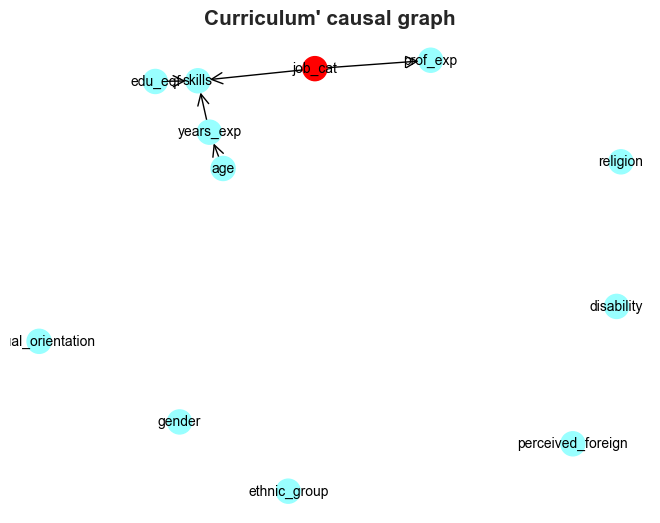

In [33]:
cf = nx.DiGraph()
cf.add_nodes_from(list(cv_dt.columns))
cf.add_edges_from([("age", "years_exp"), ("job_cat", "prof_exp"),
                   ("edu_eqf", "skills"), ("years_exp", "skills"),
                   ("job_cat", "skills")]),

node_colors = []
for node in cf.nodes():
    if node == "job_cat":
        node_colors.append("red")
    else:
        node_colors.append("#99FFFF")

pos = nx.spring_layout(cf, seed=17)
nx.draw(cf, pos,
        with_labels=True,
        node_color=node_colors,
        font_size=10,
        arrowstyle='->',
        arrowsize=20)

plt.title("Curriculum' causal graph", fontsize=15, fontweight="bold")
plt.show()

# 3 - Define the CPT (Conditional Probability Table) for used for the assignment "occupation -> skills"
We have to do this manually, since "skills" is a "set"-random variable and the DoWhy package does not support it. So we build a custom mechanism that from D_{Skills|Category,Education, Experience}, samples multiple skills following the conditional distribution.

In [34]:
cpt_skills = make_dist_from_dataframe2(data=cv_dt,
                                       X=["job_cat", "edu_eqf", "years_exp"],
                                       Y="skills",
                                       marginal_on="job_cat")

print(cpt_skills.check_distribution_validity(verbose=True))

cpt_prof_exp = make_dist_from_dataframe2(data=cv_dt,
                                         X="job_cat",
                                         Y="prof_exp")

print(cpt_prof_exp.check_distribution_validity(verbose=True))

Zero distribution : 0 on 827
Only one element distribution 12 on 827
True
Zero distribution : 0 on 20
Only one element distribution 1 on 20
True


# 4 — Define the Structural Equations Model (SEM)
We define the SEM as a list of tuples, where each tuple contains the name of the node and the mechanism used to sample it. The mechanism can be either a classifier or an empirical distribution.

In [35]:
structural_equation_model = {

    # They are root nodes, so we use the empirical distribution
    "gender": gcm.EmpiricalDistribution(),
    "disability": gcm.EmpiricalDistribution(),
    "age": gcm.EmpiricalDistribution(),
    "job_cat": gcm.EmpiricalDistribution(),
    "ethnic_group": gcm.EmpiricalDistribution(),
    "religion": gcm.EmpiricalDistribution(),
    "sexual_orientation": gcm.EmpiricalDistribution(),
    "perceived_foreign": gcm.EmpiricalDistribution(),
    "edu_eqf": gcm.EmpiricalDistribution(),

    "years_exp": gcm.ClassifierFCM(),

    # We use a custom mechanism to sample the skills since is a set-random variable
    "skills": ConditionalMechanismFromDict(cpt_data=cpt_skills, num_func=lambda x: np.random.randint(2, 8),
                                           return_always_list=True),
    "prof_exp": ConditionalMechanismFromDict(cpt_data=cpt_prof_exp, num_func=lambda x: np.random.randint(0, 2),
                                             return_always_list=True),

}

pre_processing = FunctionApplying()

# We define a set of post-processing functions to apply on the generated data
post_processing = FunctionApplying({

    # The skill node returns a str-version of a list of skills, so we need to convert the string into a list
    "skill_list": Str2ListProcessing(feature_name="ast_skills", apply_on=["skills"], replace=True),
    "prof_list": Str2ListProcessing(feature_name="ast_prof_exp", apply_on=["prof_exp"], replace=True),
})

# 5 - Fitting the SDG (Synthetic Data Generator)
We fit the SDG using the original dataset and the defined SEM. The fitting process involves learning the parameters of the causal mechanisms from the data. We also apply pre-processing and post-processing functions to transform the data before and after fitting.

In [36]:
# We create the SDG object, passing the causal graph, pre-processing and post-processing functions
sdg = CausalGenerator(direct_graph=cf,
                      post_processing=post_processing,
                      pre_processing=pre_processing)
# We fit the SDG using the original dataset and the defined SEM
_, evaluation = sdg.custom_fit(dataset=cv_dt,
                               causal_mechanisms=structural_equation_model)

Fitting causal mechanism of node prof_exp: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s] 


# 6 - Generate synthetic data
In this section, we generate synthetic data using the fitted SDG. We can specify the number of elements to generate and whether to apply any interventions on the generated data.

## 6.1 - Simple sampling
We can generate synthetic data by simply calling the sample method of the SDG object

In [37]:
sdg.sample(elements=10)

,gender,ethnic_group,religion,disability,sexual_orientation,perceived_foreign,job_cat,edu_eqf,age,years_exp,skills,prof_exp
0,No-Man,Within majority,Secular,No,Heterosexual,No,Information and communications technology prof...,level 5 or less,47,28,"[French, manage teamwork]",[irrigation system installer]
1,No-Man,Within majority,Islamic,No,LGBT+,No,"Legal, social and cultural professionals",level 6,27,0,"[adapt to change, knowledge base, determine fi...",[statistical assistant]
2,Man,Belonging to minority,Christianity,No answer,LGBT+,Yes,Information and communications technology prof...,level 7,45,30,"[office software, electronics and automation, ...",[waiter/waitress]
3,Man,Within majority,None,No answer,Heterosexual,Yes,Science and engineering associate professionals,level 6,35,12,"[project management, computer programming, adv...",[]
4,No-Man,Within majority,None,No,Heterosexual,No,Business and administration professionals,level 6,61,23,"[project management, business ICT systems, mer...",[]
5,No-Man,Within majority,None,No,LGBT+,Yes,Other clerical support workers,level 5 or less,29,9,"[use ICT ticketing system, English]",[]
6,Man,Within majority,Other,No,LGBT+,No,Personal service workers,level 5 or less,20,3,"[show professional responsibility, working eff...",[forest worker]
7,Man,Within majority,None,No,Heterosexual,No,"Legal, social and cultural professionals",level 6,36,8,"[English, planning and organising, social netw...",[]
8,Man,Belonging to minority,None,No,Heterosexual,No,Science and engineering associate professionals,level 6,25,1,"[consult with business clients, computer graph...",[]
9,No-Man,Within majority,No answer,No,Heterosexual,Yes,Information and communications technology prof...,level 7,No answer,4,"[collaborate in company's daily operations, CS...",[editorial assistant]


## 6.2 - Sampling with interventions
We can also generate synthetic data with interventions by specifying the values of the features we want to intervene on. For example, we can set the gender (or age) to a fixed value (hard intervention)

In [38]:
sdg.sample(interventions={"gender": lambda x: "Man", "age": lambda x: "36"},
           elements=10)

,gender,ethnic_group,religion,disability,sexual_orientation,perceived_foreign,job_cat,edu_eqf,age,years_exp,skills,prof_exp
0,Man,No answer,Islamic,No,LGBT+,No,Science and engineering associate professionals,level 5 or less,36,11,"[principles of combustion engines, operating s...",[membership manager]
1,Man,No answer,None,No,Heterosexual,No,Teaching professionals,level 6,36,25,"[electronics and automation, Italian, develop ...",[science teacher secondary school]
2,Man,Within majority,None,No answer,Heterosexual,No,Craft and related trades workers,level 5 or less,36,16,"[computer graphics, English, work in a hospita...",[]
3,Man,Within majority,None,No,LGBT+,No,Production and specialised services managers,level 5 or less,36,11,[International Maritime Organisation conventio...,[]
4,Man,Within majority,No answer,No,Heterosexual,Yes,Commissioned armed forces officers,level 5 or less,36,1,"[assist customers, Spanish]",[]
5,Man,Within majority,Judaism,No,Heterosexual,No,"Chief executives, senior officials and legisla...",level 6,36,18,"[computer programming, plan social media marke...",[]
6,Man,Within majority,Christianity,No,Heterosexual,No,"Legal, social and cultural professionals",level 5 or less,36,14,"[investigation research methods, English, comp...",[]
7,Man,Within majority,No answer,No,Heterosexual,Yes,Science and engineering professionals,level 5 or less,36,29,"[conduct scholarly research, be friendly to pa...",[nurse assistant]
8,Man,Within majority,No answer,Yes,LGBT+,No,Teaching professionals,level 6,36,29,[manage different departments in a hospitality...,[sales support assistant]
9,Man,Within majority,Secular,Yes,Heterosexual,No,Business and administration professionals,level 5 or less,36,5,"[develop digital content, geometry, computer p...",[secretary]


In [39]:
sdt = sdg.sample_and_save(
    folder=".",
    name=f"synthetic_example.json",
    elements=2000,
    verbose=False,
    fill_missing="uniform",
    apply_post_processing=True,
    add_file_info=True
)